# Client 2 Electricity

### Imports

In [25]:
import warnings
import sys
import os.path
import math
sys.path.insert(0, os.path.abspath('../../../../functions'))
from knmi_weather import knmi_weather as knmi # eda tools
from sp_ql import Engine
import pandas as pd
import statistics
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from math import ceil
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
import joblib
import seaborn as sns
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

### Defs

In [26]:
def calc_soc_pos_on_plot(df_compare_monthly, soc):
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

### Read Inputs

In [7]:
project = 'MERIN' #change to Merin
engine=Engine(project=project, isAsync=False)
bms_registers = engine.list().filter(unit='CELCIUS').all()
build_names = bms_registers['keyname_01'].unique()
build_names = build_names[~pd.isna(build_names)]
eans=pd.read_csv(f'/Users/Matt/Desktop/MSc/Thesis/Spectral/brighter_eda/inputs/eans/{project.lower()}_eans.csv')
#extraction of unique keyname_01 and EAN for electricity
electr_eans=eans[eans['Contract Type']=='Electricity']
electr_eans=electr_eans[['keyname_01', 'EAN']].dropna().set_index('keyname_01').squeeze()

#adds missing buildings
for building in build_names:
    if building not in electr_eans.index:
        electr_eans[building]=np.nan

In [1]:
del electr_eans['POLAR130']
del electr_eans['CRBA_CAP']
del electr_eans['CRBB_CAP']
del electr_eans['AQUARIUS']
del electr_eans['SPICALN1']
del electr_eans['HBW1ADAM']
del electr_eans['OVSAM184']
del electr_eans['OVSAM186']
del electr_eans['OVSAM61']
del electr_eans['TRW32ADM']
del electr_eans['TUPLEV65'] #not enough training data

In [658]:
#removes two buildings from build_names which have both no electricity and gas EAN data
build_names=np.delete(build_names, 10, axis=None)

In [659]:
# determine building location
cities = eans[['keyname_01', 'City']].dropna()
cities = cities.drop_duplicates().set_index('keyname_01').squeeze()
cities['P163063']='Amsterdam' #manually adding: Derkinderenstraat=P163063=Amsterdam
cities['RADPAMS_ALL']='Amsterdam' #change later
cities['RADPAMS']='Amsterdam' #change later
cities['R003331_ALL']='Amsterdam' #change later
cities['R003331']='Amsterdam' #change later
# read and preprocess weather data
knmi_station_lookup = pd.read_csv(r'../../../../inputs/knmi/knmi_uurgegevens/city_knmi_station_lookup.csv', index_col=0, squeeze=True)
#KeyError: "['RADPAMS_ALL', 'R003331_ALL', 'P23584', 'R003331', 'RADPAMS'] not in index"
t = cities.to_frame()
t = t[~t.index.duplicated(keep='first')]
cities=t.squeeze()

In [13]:
# read in start of control dates, just reads the file
socs = pd.read_csv(r'../../../../inputs/start_of_control/start_of_control_dates.csv')
socs = socs[socs['project']==project]
socs = socs.set_index('keyname_01')['soc_date'].squeeze()
socs = pd.to_datetime(socs)

In [20]:
data_periods = pd.DataFrame()
data_periods['start'] = socs[electr_eans.index] - dt.timedelta(days=365)
data_periods['end'] = socs[electr_eans.index]
data_periods=data_periods.drop_duplicates(subset=['start'])
data_periods.loc['GPR_EH', 'start']

Timestamp('2018-03-15 00:00:00')

### Pulling data

In [ ]:
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use = pd.DataFrame(index=pd.date_range(start=data_periods['start'].min(),
                                              end=data_periods['end'].max(),
                                              freq=time_res))

# pulls data from sp-ql
electr_builds = ['GPR_EH', 'HGHW8ADM', 'KRSD8ADM', 'VOGELSTR', 'HGHW4ADM', 'WEND_163']
for building in [b for b in build_names if b in electr_builds]:
#skips buildings with no electricity EAN data
    start = data_periods.loc[building, 'start']
    end = data_periods.loc[building, 'end']
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use = electr_use.join(electr)
        #else:
            #print(fr'{building} - electricity EAN:{electr_eans[building]} not found')
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use = electr_use.join(electr)
            #else:
                #print(fr'{building} - electricity EAN:{ean} not found')
electr_use = electr_use.resample('d').sum() #sums the kWh to daily readings
filter_col = [col for col in electr_use if col.startswith('WEND')] #filters the buildings that start with input name
electr_use[filter_col]=electr_use[filter_col].fillna(0) #adds 0's for NaN's for summation of electricity usage
electr_use['WEND_ALL']=electr_use[filter_col].sum(axis=1) #summation of all buildings with name filter
electr_use['WEND_ALL']=electr_use['WEND_ALL'].replace({'0':np.nan, 0:np.nan}) #replacing the 0's back for NaN's
electr_use=electr_use.drop(['WEND_163_871685920002511933', 'WEND_163_871685900041513587'], axis=1)
electr_use.rename(columns = {'GPR_EH_871688730000013981':'GPR_EH', 'HGHW8ADM_871685900000033811':'HGHW8ADM', 'KRSD8ADM_871685900000033903':'KRSD8ADM', 
                                     'VOGELSTR_871685900000033682':'VOGELSTR', 'HGHW4ADM_871685900000033798':'HGHW4ADM', 'TUPLEV65_871685900007082409':'TUPLEV65',
                             'WEND_ALL':'WEND_163'}, inplace = True)

In [663]:
weather = {}
for station in knmi_station_lookup.unique():
    knmi_weather_file_1 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2011-2020.txt'
    knmi_weather_file_2 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2021-2030.txt'
    knmi_weather = pd.read_csv(knmi_weather_file_1,
                               skiprows=31,
                               skipinitialspace=True,
                               usecols=list(range(1, 25)))
    knmi_weather = knmi_weather.append(pd.read_csv(knmi_weather_file_2,
                                                   skiprows=31,
                                                   skipinitialspace=True,
                                                   usecols=list(range(1, 25))))
    # making proper index for KNMI weather data
    knmi_weather.index = knmi.convert_knmi_dates(date=knmi_weather['YYYYMMDD'],
                                                 hour=knmi_weather['HH'])
    # clean up values
    knmi_weather = knmi.cleanup_knmi_units(knmi_weather=knmi_weather)
    weather[station] = knmi_weather

In [664]:
#was used for forecasting later on
#knmi_weather=weather[275]
#features = pd.DataFrame()
#features['SQ'] = knmi_weather['SQ'].resample('d').mean()
#features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
#features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
#features.to_csv('features_275.csv')

In [665]:
## Determine training and prediction intervals
train_periods = pd.DataFrame()
train_periods['end'] = socs[electr_use.columns]
train_periods['start'] = socs[electr_use.columns] - dt.timedelta(days=365) #more training data=better
train_periods = train_periods[~train_periods.index.duplicated(keep='first')]
train_periods

,end,start
GPR_EH,2019-03-15,2018-03-15
HGHW8ADM,2020-09-06,2019-09-07
KRSD8ADM,2020-12-10,2019-12-11
VOGELSTR,2021-07-21,2020-07-21
HGHW4ADM,2021-07-20,2020-07-20
WEND_163,2021-01-11,2020-01-12


In [666]:
electr_use.to_csv(r'MERIN_electr/data/electr_use_train.csv')

In [667]:
# some buildings have small gaps in gas data. We can interpolate over these
electr_use_train = pd.read_csv(r'MERIN_electr/data/electr_use_train.csv', index_col=0,
                            parse_dates=True)

In [668]:
for building in electr_use.columns:
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    electr_use_train_build = electr_use_train.loc[start_train:end_train, building]
    #setting first element to 0 if nan. To aid interpolation.
    if electr_use_train_build.iloc[[0]].isna()[0]:
        electr_use_train_build.iloc[0] = 0
    electr_use_train_build = electr_use_train_build.interpolate(limit=10) # filling max 10 consecutive days of missing data?
    electr_use_train.loc[start_train:end_train, building] = electr_use_train_build

### Random Forest

In [669]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()

    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    
    electr_use_train_build = electr_use[building]
    
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'MERIN_electr/data/trained_models/rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_electr/data/trained_models/rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_electr/data/trained_models/rf/y_test_{building}.joblib')

Training building GPR_EH, 1/6
Training building HGHW8ADM, 2/6
Training building KRSD8ADM, 3/6
Training building VOGELSTR, 4/6
Training building HGHW4ADM, 5/6
Training building WEND_163, 6/6


### Gradient Boosting Regressor

In [670]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()

    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    
    electr_use_train_build = electr_use[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }
    
    rf = GradientBoostingRegressor()
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                        cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    
    joblib.dump(grid_search.best_estimator_, fr'MERIN_electr/data/trained_models/gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_electr/data/trained_models/gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_electr/data/trained_models/gb/y_test_{building}.joblib')

Training building GPR_EH, 1/6
Training building HGHW8ADM, 2/6
Training building KRSD8ADM, 3/6
Training building VOGELSTR, 4/6
Training building HGHW4ADM, 5/6
Training building WEND_163, 6/6


### XGBoosting

In [671]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()
    
    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek

    electr_use_train_build = electr_use[building]
    X = features[(features.index >= start_train) & (features.index < end_train)] #KNMI data (used for training) before SOC (10-12months) up until SOC
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)

    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'MERIN_electr/data/trained_models/xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_electr/data/trained_models/xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_electr/data/trained_models/xg/y_test_{building}.joblib')

Training building GPR_EH, 1/6
Training building HGHW8ADM, 2/6
Training building KRSD8ADM, 3/6
Training building VOGELSTR, 4/6
Training building HGHW4ADM, 5/6
Training building WEND_163, 6/6


In [745]:
importance={}
for building in electr_use.columns:
    models = os.listdir('MERIN_electr/data/trained_models/xg') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_electr/data/trained_models/xg/trained_{building}.joblib') #change for RF, GB, XG
        importance[building]=grid_search.feature_importances_
importance_df=pd.concat({k: pd.DataFrame(v) for k, v in importance.items()}, axis=1)
importance_df['mean'] = importance_df.mean(axis=1)
importance_df.insert(0, 'FEATURE', features.columns)
importance_df=importance_df.set_index(importance_df.columns[0])
importance_df=importance_df.sort_values(by=['mean'],ascending=False)
importance_df

,GPR_EH,HGHW8ADM,KRSD8ADM,VOGELSTR,HGHW4ADM,WEND_163,mean
,0,0,0,0,0,0,
"(FEATURE, )",,,,,,,
dow,0.974614,0.932349,0.786790,0.702862,0.933736,0.526382,0.809455
daily_mean_OAT,0.014202,0.022348,0.128443,0.113750,0.035131,0.263516,0.096232
daily_sum_GHI,0.003950,0.028522,0.046592,0.111253,0.013252,0.129398,0.055495
SQ,0.007235,0.016781,0.038176,0.072135,0.017880,0.080704,0.038818


### Metrics - single

In [746]:
# reading in saved trained RF models and calculating mae for the test set
mae_range_percent = pd.Series()
for building in electr_use.columns:
    models = os.listdir('MERIN_electr/data/trained_models/rf') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_electr/data/trained_models/rf/trained_{building}.joblib') #change for RF, GB, XG
        X_test = joblib.load(fr'MERIN_electr/data/trained_models/rf/X_test_{building}.joblib') #change for RF, GB, XG
        y_test = joblib.load(fr'MERIN_electr/data/trained_models/rf/y_test_{building}.joblib') #change for RF, GB, XG
    #
    # grid search already contains the re-trained model with the best parameters
    y_test_pred = grid_search.predict(X_test)
    #
    # calculating MAE and plotting test and pred_test
    mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    # mae in percent of range
    mae_range_percent[building] = mae / y_test.max() * 100
    
    electr_use_train_build = electr_use[building]

In [747]:
statistics.mean(mae_range_percent)

5.763332972984917

### Metrics together - MAE

In [748]:
metric_com_mae = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'MERIN_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        electr_use_train_build = electr_use[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

In [749]:
metric_com_mae

,RF,GB,XG
GPR_EH,2.929368,5.189341,3.290119
HGHW8ADM,5.359978,8.013320,5.009125
KRSD8ADM,6.215014,8.029709,7.206966
VOGELSTR,8.966316,7.511495,7.038114
HGHW4ADM,5.493824,5.984296,6.028627
WEND_163,5.615498,7.445986,5.391685


### Metrics together - RMSE

In [750]:
metric_com_rmse = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'MERIN_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

### Stacked ensembling - MAE

In [751]:
en_mae = pd.DataFrame(index=electr_use.columns) #verander naam van variabele
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'MERIN_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]
    

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100
    
    en_mae['EN']=mae_range_percent
    
print(en_mae)

                EN
GPR_EH    3.022420
HGHW8ADM  4.109875
KRSD8ADM  6.619281
VOGELSTR  6.136673
HGHW4ADM  4.825104
WEND_163  4.053027


### MAEs together

In [752]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                RF        GB        XG        EN
GPR_EH    2.929368  5.189341  3.290119  3.022420
HGHW8ADM  5.359978  8.013320  5.009125  4.109875
KRSD8ADM  6.215014  8.029709  7.206966  6.619281
VOGELSTR  8.966316  7.511495  7.038114  6.136673
HGHW4ADM  5.493824  5.984296  6.028627  4.825104
WEND_163  5.615498  7.445986  5.391685  4.053027


Average MAEs


RF    5.76333
GB    7.02902
XG    5.66077
EN    4.79440
dtype: float64

### Stacked Ensembling - RMSE

In [753]:
en_rmse = pd.DataFrame(index=electr_use.columns) #verander naam van variabele
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'MERIN_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent
    

### RMSEs together

In [754]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                 RF         GB        XG        EN
GPR_EH     5.118681   6.432792  4.959721  3.985080
HGHW8ADM   8.586757  11.112114  7.012249  5.280960
KRSD8ADM   8.383713  10.613314  9.337157  8.209803
VOGELSTR  13.194415  10.645226  9.974279  7.733783
HGHW4ADM   9.193933   8.897604  8.227482  6.776463
WEND_163   7.098825   9.732385  7.182562  5.394823


Average RMSEs


RF    8.59605
GB    9.57224
XG    7.78224
EN    6.23015
dtype: float64

# All models

### Adding ensemble predictions

### Deeper comparison of all 3 models

In [756]:
electr_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in electr_use.columns:
        # select weather data for prediction
        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]
        # preapare features for prediction
        features = pd.DataFrame()
        features['SQ'] = knmi_weather['SQ'].resample('d').mean()
        features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
        features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
        features['dow'] = features.index.dayofweek
        
        #features['month'] = features.index.month
        X_pred = features
        # do the predictions
        models = os.listdir(f'MERIN_electr/data/trained_models/{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        electr_use_pred[building+'_'+m] = y_pred

In [757]:
#ensemble stacking, equal weight
electr_use_pred['GPR_EH_en']=(electr_use_pred['GPR_EH_rf']+electr_use_pred['GPR_EH_gb']+electr_use_pred['GPR_EH_xg'])/3
electr_use_pred['HGHW8ADM_en']=(electr_use_pred['HGHW8ADM_rf']+electr_use_pred['HGHW8ADM_gb']+electr_use_pred['HGHW8ADM_xg'])/3
electr_use_pred['KRSD8ADM_en']=(electr_use_pred['KRSD8ADM_rf']+electr_use_pred['KRSD8ADM_gb']+electr_use_pred['KRSD8ADM_xg'])/3
electr_use_pred['VOGELSTR_en']=(electr_use_pred['VOGELSTR_rf']+electr_use_pred['VOGELSTR_gb']+electr_use_pred['VOGELSTR_xg'])/3
electr_use_pred['HGHW4ADM_en']=(electr_use_pred['HGHW4ADM_rf']+electr_use_pred['HGHW4ADM_gb']+electr_use_pred['HGHW4ADM_xg'])/3
electr_use_pred['WEND_163_en']=(electr_use_pred['WEND_163_rf']+electr_use_pred['WEND_163_gb']+electr_use_pred['WEND_163_xg'])/3

In [758]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                              end=knmi_weather.index[-1],
                                              freq=time_res))
# pulls data from sp-ql
electr_builds = ['GPR_EH', 'HGHW8ADM', 'KRSD8ADM', 'VOGELSTR', 'HGHW4ADM', 'WEND_163']
for building in [b for b in build_names if b in electr_builds]:
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use_meas = electr_use_meas.join(electr)
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use_meas = electr_use_meas.join(electr)

### Cleaning

In [759]:
electr_use_meas = electr_use_meas.resample('d').sum()
filter_col = [col for col in electr_use_meas if col.startswith('WEND')] #filters the buildings that start with input name
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0) #adds 0's for NaN's for summation of electricity usage
electr_use_meas['WEND_ALL']=electr_use_meas[filter_col].sum(axis=1) #summation of all buildings with name filter
electr_use_meas['WEND_ALL']=electr_use_meas['WEND_ALL'].replace({'0':np.nan, 0:np.nan}) #replacing the 0's back for NaN's
electr_use_meas=electr_use_meas.drop(['WEND_163_871685920002511933', 'WEND_163_871685900041513587'], axis=1)
electr_use_meas.rename(columns = {'GPR_EH_871688730000013981':'GPR_EH_rf', 'HGHW8ADM_871685900000033811':'HGHW8ADM_rf', 'KRSD8ADM_871685900000033903':'KRSD8ADM_rf', 
                                     'VOGELSTR_871685900000033682':'VOGELSTR_rf', 'HGHW4ADM_871685900000033798':'HGHW4ADM_rf', 'TUPLEV65_871685900007082409':'TUPLEV65_rf',
                             'WEND_ALL':'WEND_163_rf'}, inplace = True)

In [760]:
for m in ['gb','xg']:
    for building in electr_use.columns:
        electr_use_meas[building+"_"+m]=electr_use_meas[building+"_rf"]

In [761]:
electr_use_meas.columns

Index(['GPR_EH_rf', 'HGHW8ADM_rf', 'KRSD8ADM_rf', 'VOGELSTR_rf', 'HGHW4ADM_rf',
       'WEND_163_rf', 'GPR_EH_gb', 'HGHW8ADM_gb', 'KRSD8ADM_gb', 'VOGELSTR_gb',
       'HGHW4ADM_gb', 'WEND_163_gb', 'GPR_EH_xg', 'HGHW8ADM_xg', 'KRSD8ADM_xg',
       'VOGELSTR_xg', 'HGHW4ADM_xg', 'WEND_163_xg'],
      dtype='object')

In [762]:
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()

for m in ['rf','gb','xg']:
    for building in electr_use_meas.columns:
        size = len(building)
        start = train_periods.loc[building[:size-3], 'start']
        end = knmi_weather.index[-1]
        soc = socs[building[:size-3]]
        electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('d').sum()
        electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('d').sum()
        month_saving = (electr_use_pred_m - electr_use_meas_m) / electr_use_pred_m * 100
        month_savings[building] = month_saving
        month_savings_m3[building] = electr_use_pred_m - electr_use_meas_m
        total_savings_m3[building] = (electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum()
        total_savings_perc[building] = total_savings_m3[building] / electr_use_pred.loc[soc:, building].sum() * 100

train_pred_mae = pd.Series()
for m in ['rf','gb','xg']:
    for building in electr_use_meas.columns:
        size = len(building)
        soc = socs[building[:size-3]]
        start = train_periods.loc[building[:size-3], 'start']
        end = train_periods.loc[building[:size-3], 'end'] #knmi_weather.index[-1]
        electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('d').sum()
        electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('d').sum()
        electr_use_month_mae = mean_absolute_error(y_true=electr_use_meas_m, y_pred=electr_use_pred_m)
        train_pred_mae[building] = electr_use_month_mae

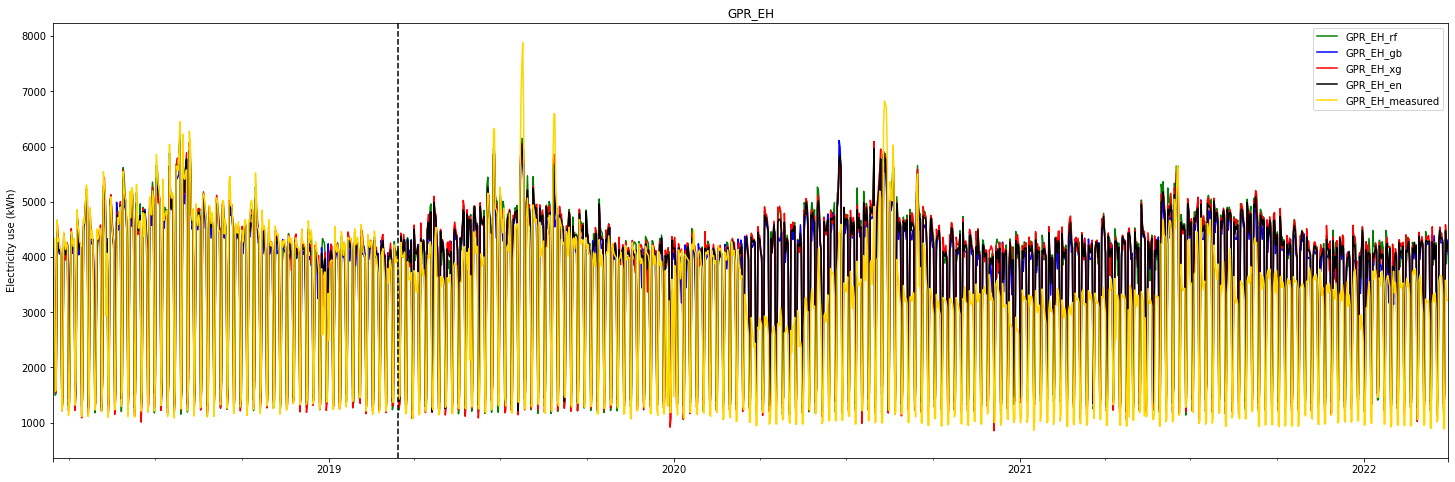

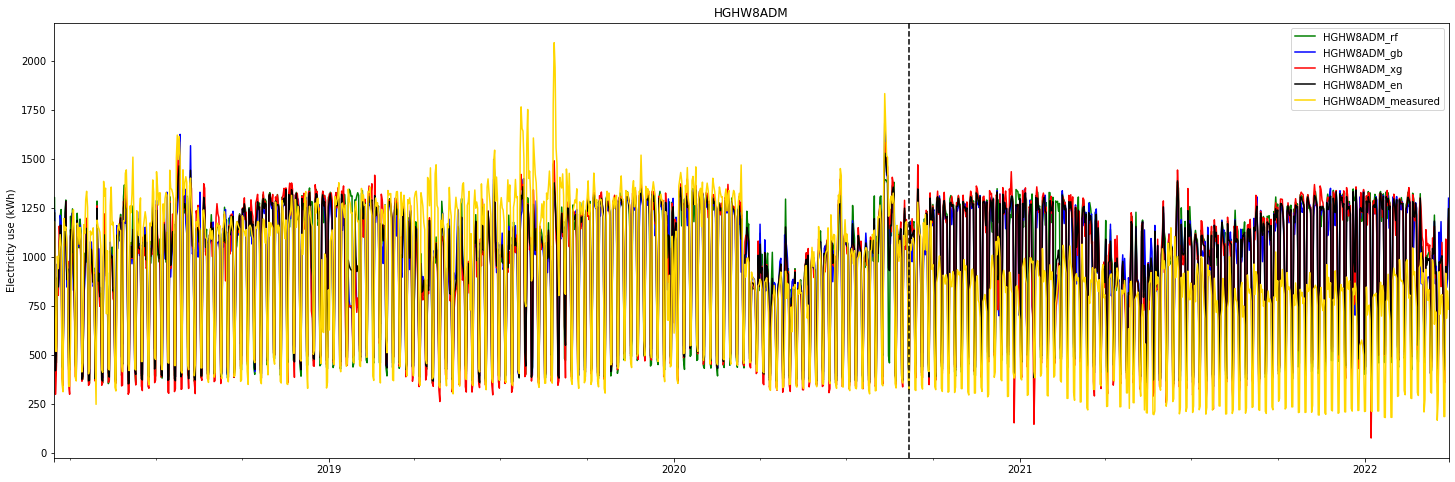

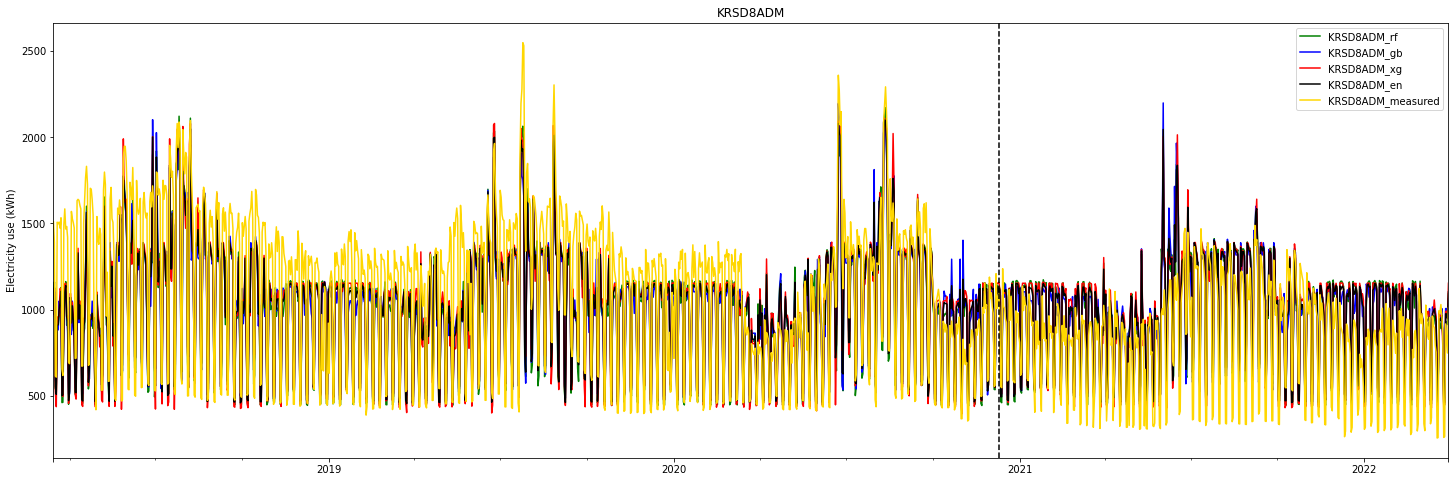

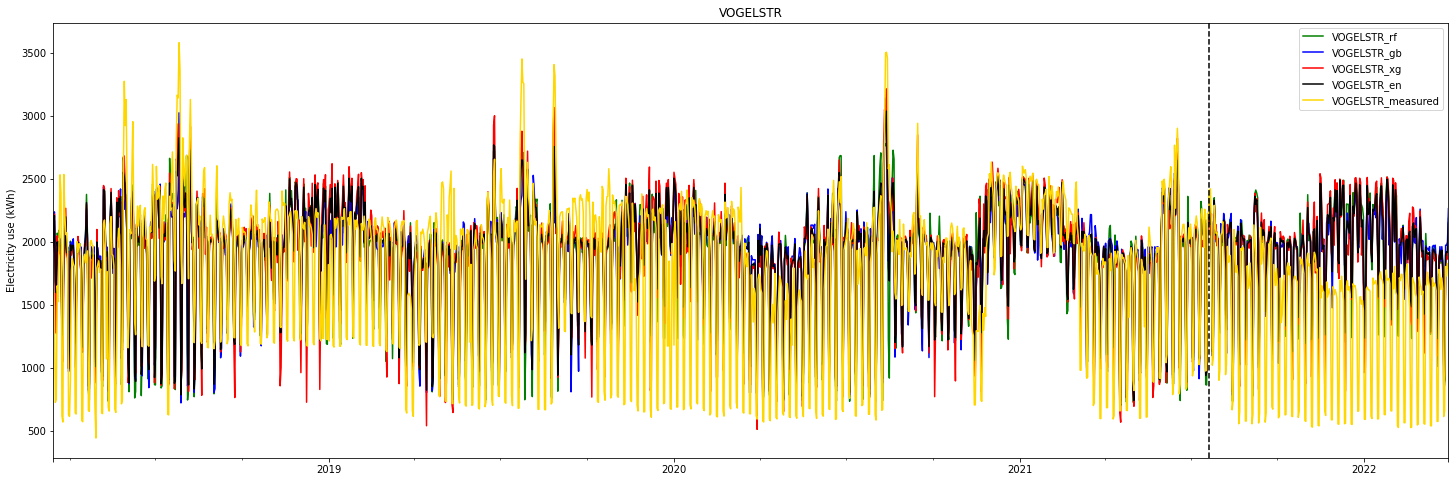

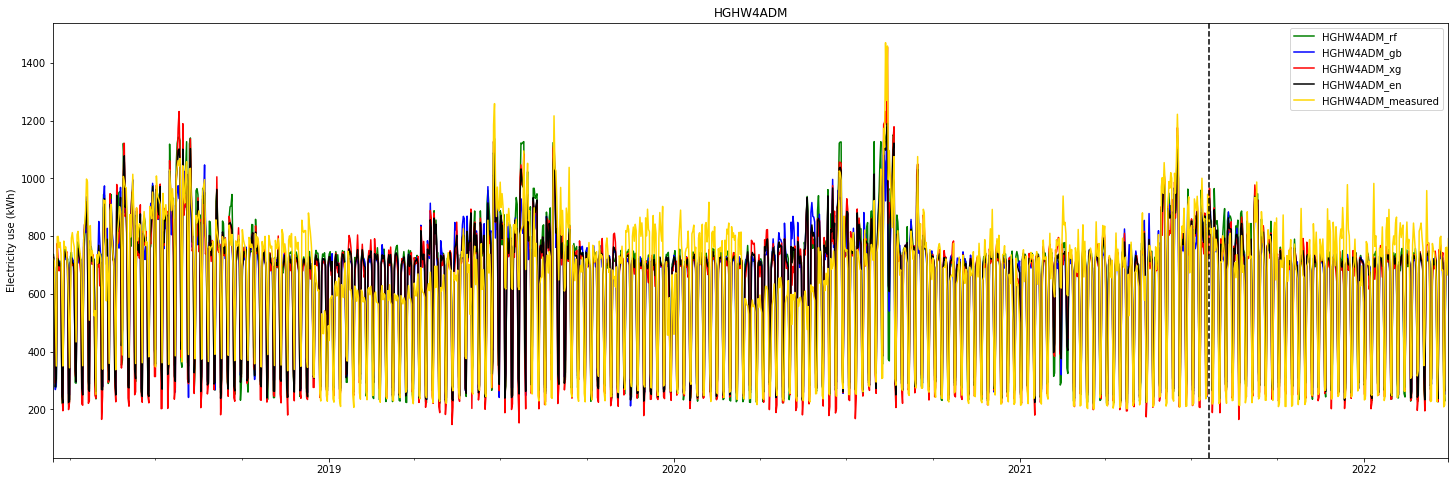

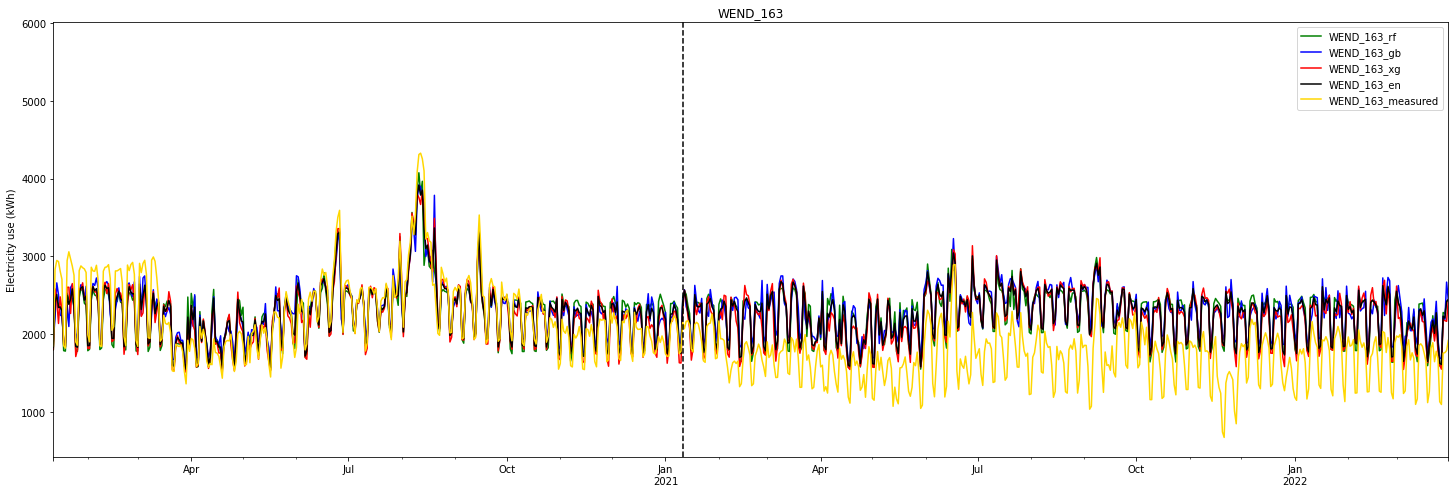

In [763]:
for building in electr_use.columns:
    t=pd.DataFrame()
    fig, ax = plt.subplots(figsize=(25, 8))
    electr_use_pred[building+"_rf"].plot(ax=ax, color='green')
    electr_use_pred[building+"_gb"].plot(ax=ax, color='blue')
    electr_use_pred[building+"_xg"].plot(ax=ax, color='red')
    electr_use_pred[building+"_en"].plot(ax=ax, color='black')
    t[building+"_measured"]=electr_use_meas[building+"_rf"]
    t.plot(ax=ax, color='gold')
    #electr_use_pred_en[building].plot(ax=ax, color='black')
    ax.set_xlim(left=electr_use_train[building].dropna().index[0])
    ax.set_title(building)
    ax.set_ylabel('Electricity use (kWh)')
    ax.legend()
    ax.axvline(x=socs[building], color='k', ls='--')
    plt.show(block=False)

### Comparison of individual models

In [847]:
electr_use_pred = pd.DataFrame(index=features.index)
for building in electr_use.columns:
    # select weather data for prediction
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    # preapare features for prediction
    features = pd.DataFrame()
    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek

    #features['month'] = features.index.month
    X_pred = features
    # do the predictions
    models = os.listdir(f'MERIN_electr/data/trained_models/xg')
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_electr/data/trained_models/xg/trained_{building}.joblib')
    y_pred = grid_search.predict(X_pred)
    electr_use_pred[building] = y_pred

In [848]:
electr_use_pred

,GPR_EH,HGHW8ADM,KRSD8ADM,VOGELSTR,HGHW4ADM,WEND_163
2011-01-01,1485.167847,445.597961,546.441223,2082.333008,166.179367,1723.988403
2011-01-02,892.102539,467.928192,558.116394,1939.672974,273.000549,1614.792725
2011-01-03,4449.474609,783.727295,1159.524414,2493.874756,692.482544,2273.657715
2011-01-04,4192.773926,772.255798,1154.245728,2508.625244,710.488220,2242.613525
2011-01-05,4241.477051,783.727295,1146.023560,2478.197754,708.956787,2250.951416
...,...,...,...,...,...,...
2022-03-27,1463.389893,357.837585,453.415894,940.785645,308.421509,1549.824341
2022-03-28,4587.317871,1090.763794,990.201477,1831.157104,742.567139,2185.988281
2022-03-29,4213.265137,908.479858,990.201477,1879.705566,751.949219,2174.002930
2022-03-30,4190.751465,1062.785522,961.952820,1861.226196,751.545288,2164.503418


In [849]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                              end=knmi_weather.index[-1],
                                              freq=time_res))
# pulls data from sp-ql
electr_builds = ['GPR_EH', 'HGHW8ADM', 'KRSD8ADM', 'VOGELSTR', 'HGHW4ADM', 'WEND_163']
for building in [b for b in build_names if b in electr_builds]:
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use_meas = electr_use_meas.join(electr)
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use_meas = electr_use_meas.join(electr)

In [850]:
electr_use_meas = electr_use_meas.resample('d').sum()
filter_col = [col for col in electr_use_meas if col.startswith('WEND')] #filters the buildings that start with input name
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0) #adds 0's for NaN's for summation of electricity usage
electr_use_meas['WEND_ALL']=electr_use_meas[filter_col].sum(axis=1) #summation of all buildings with name filter
electr_use_meas['WEND_ALL']=electr_use_meas['WEND_ALL'].replace({'0':np.nan, 0:np.nan}) #replacing the 0's back for NaN's

In [851]:
electr_use_meas=electr_use_meas.drop(['WEND_163_871685920002511933', 'WEND_163_871685900041513587'], axis=1)

In [852]:
electr_use_meas.rename(columns = {'GPR_EH_871688730000013981':'GPR_EH', 'HGHW8ADM_871685900000033811':'HGHW8ADM', 'KRSD8ADM_871685900000033903':'KRSD8ADM', 
                                     'VOGELSTR_871685900000033682':'VOGELSTR', 'HGHW4ADM_871685900000033798':'HGHW4ADM', 'TUPLEV65_871685900007082409':'TUPLEV65',
                             'WEND_ALL':'WEND_163'}, inplace = True)

In [853]:
electr_use_meas

,GPR_EH,HGHW8ADM,KRSD8ADM,VOGELSTR,HGHW4ADM,WEND_163
2018-03-15,4182.235031,1168.339997,1509.275011,1614.254997,720.932498,3026.817532
2018-03-16,4345.702480,1179.577496,1391.207489,1483.732485,712.270007,2914.502503
2018-03-17,1566.157501,518.894997,614.577497,724.507500,534.217501,1887.600004
2018-03-18,1587.259991,516.622499,608.552504,749.750000,349.715001,1832.589998
2018-03-19,4670.910042,1002.870010,1507.099997,1649.705011,798.402502,3105.104947
...,...,...,...,...,...,...
2022-03-27,891.057800,183.992200,263.741199,654.973301,214.270298,1095.272102
2022-03-28,3579.851410,916.128290,916.859215,1802.537001,759.202104,1755.873199
2022-03-29,3264.166790,686.689199,832.534904,1728.586109,761.554600,1761.683212
2022-03-30,3216.183220,826.037105,748.161599,1825.656614,665.460102,1789.152000


In [854]:
electr_use_meas.to_csv(r'electr_use_meas.csv')

In [855]:
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()
for building in electr_use_meas.columns:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    soc = socs[building]
    electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('m').sum()
    electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('m').sum()
    month_saving = (electr_use_pred_m - electr_use_meas_m) / electr_use_pred_m * 100
    month_savings[building] = month_saving
    month_savings_m3[building] = electr_use_pred_m - electr_use_meas_m
    total_savings_m3[building] = (electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = total_savings_m3[building] / electr_use_pred.loc[soc:, building].sum() * 100

train_pred_mae = pd.Series()
for building in electr_use_meas.columns:
    soc = socs[building]
    start = train_periods.loc[building, 'start']
    end = train_periods.loc[building, 'end'] #knmi_weather.index[-1]
    electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('m').sum()
    electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('m').sum()
    electr_use_month_mae = mean_absolute_error(y_true=electr_use_meas_m, y_pred=electr_use_pred_m)
    train_pred_mae[building] = electr_use_month_mae

In [856]:
total_savings_m3

GPR_EH      698586.701605
HGHW8ADM    148628.391954
KRSD8ADM     73370.561305
VOGELSTR    117648.228722
HGHW4ADM     -3966.448730
WEND_163    235579.403055
dtype: float64

In [857]:
for building in electr_use_meas.columns:
    total_savings_m3[building] = (electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = ((electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum() / electr_use_pred.loc[soc:, building].sum()) * 100
total_savings_perc

GPR_EH      21.082546
HGHW8ADM    28.192403
KRSD8ADM    16.377139
VOGELSTR    13.859628
HGHW4ADM    -2.726426
WEND_163    23.848634
dtype: float64

In [876]:
from datetime import date
from dateutil.relativedelta import relativedelta

2021-01-11 00:00:00


Timestamp('2020-07-11 00:00:00')

106832.26526673634


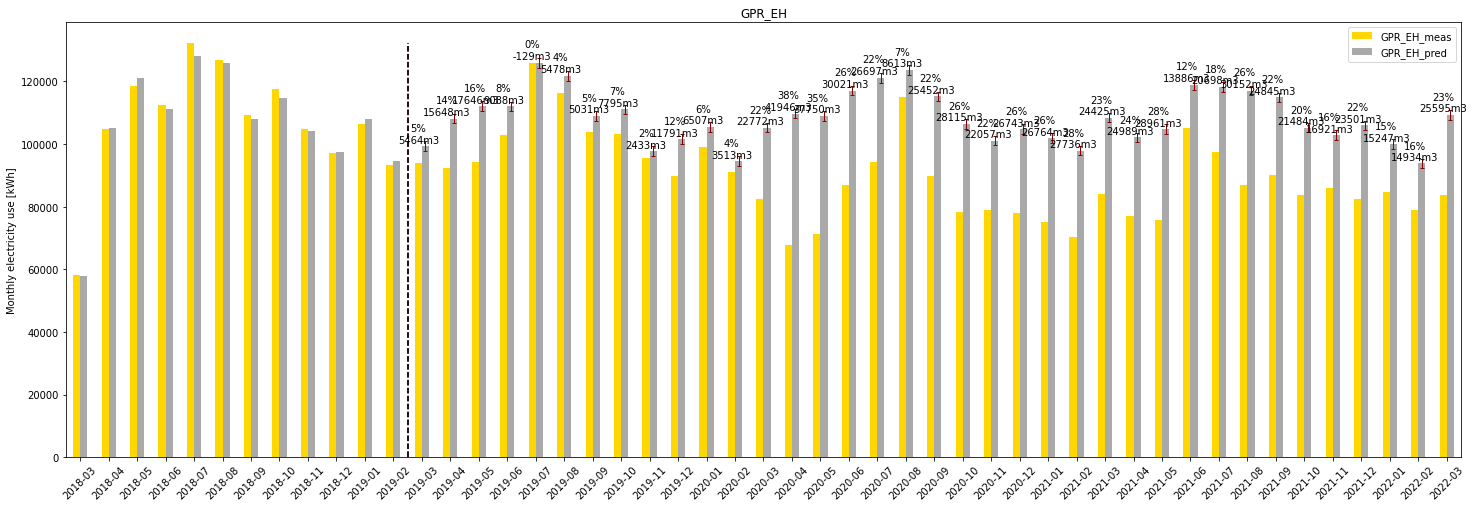

28294.695193767548


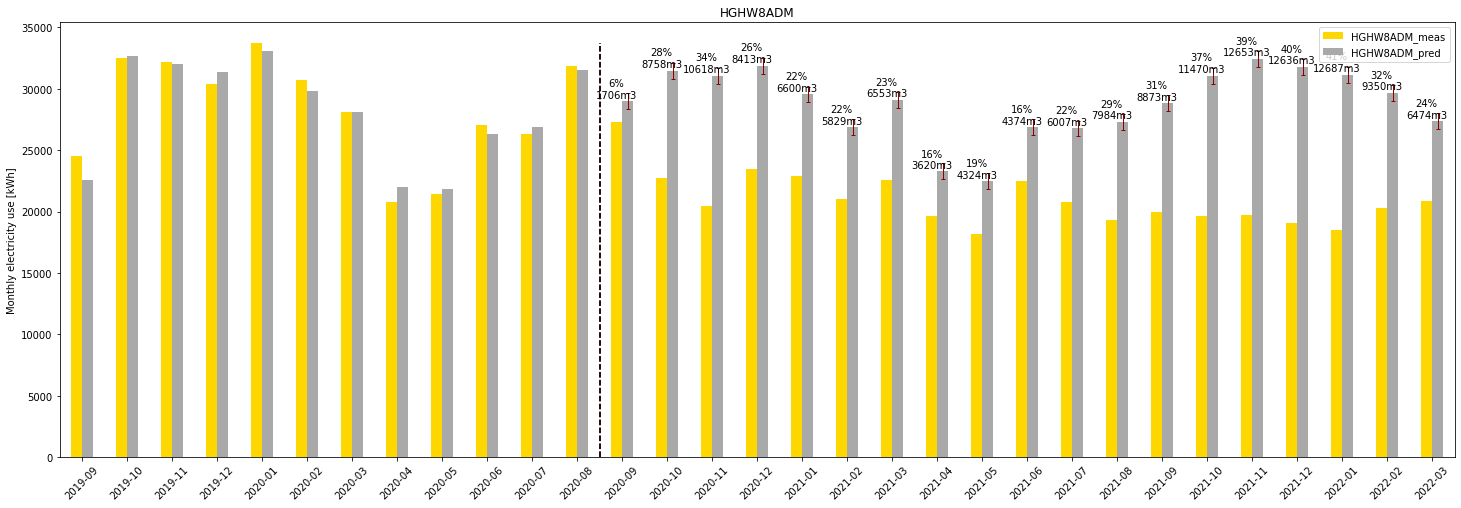

29407.496247291565


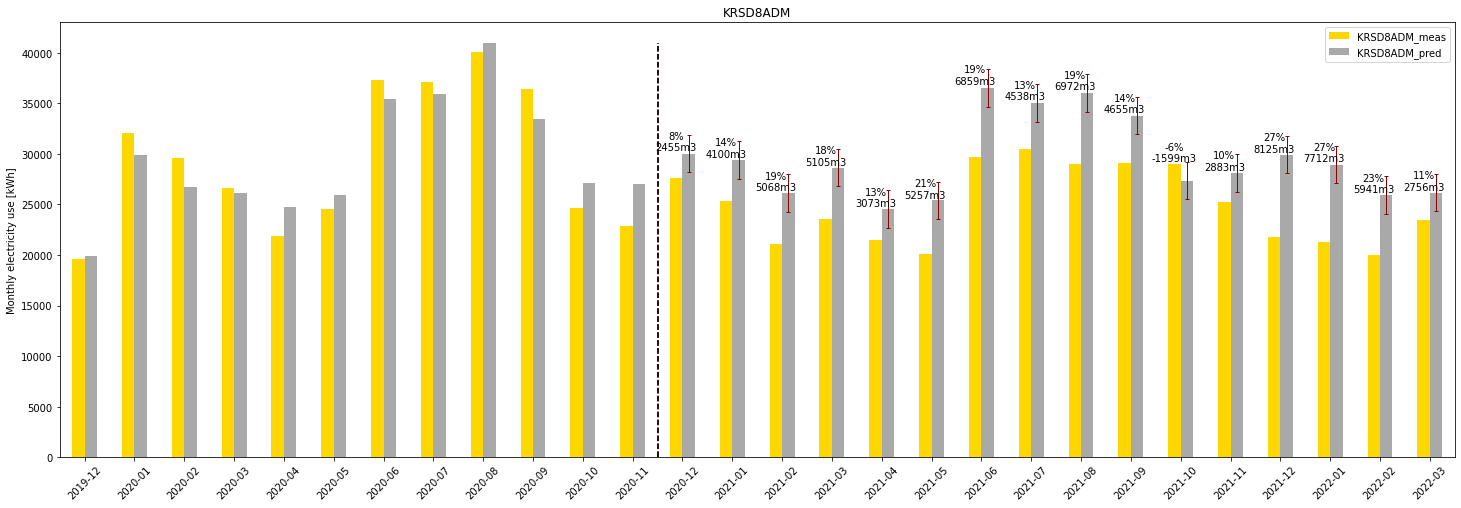

54483.58079767227


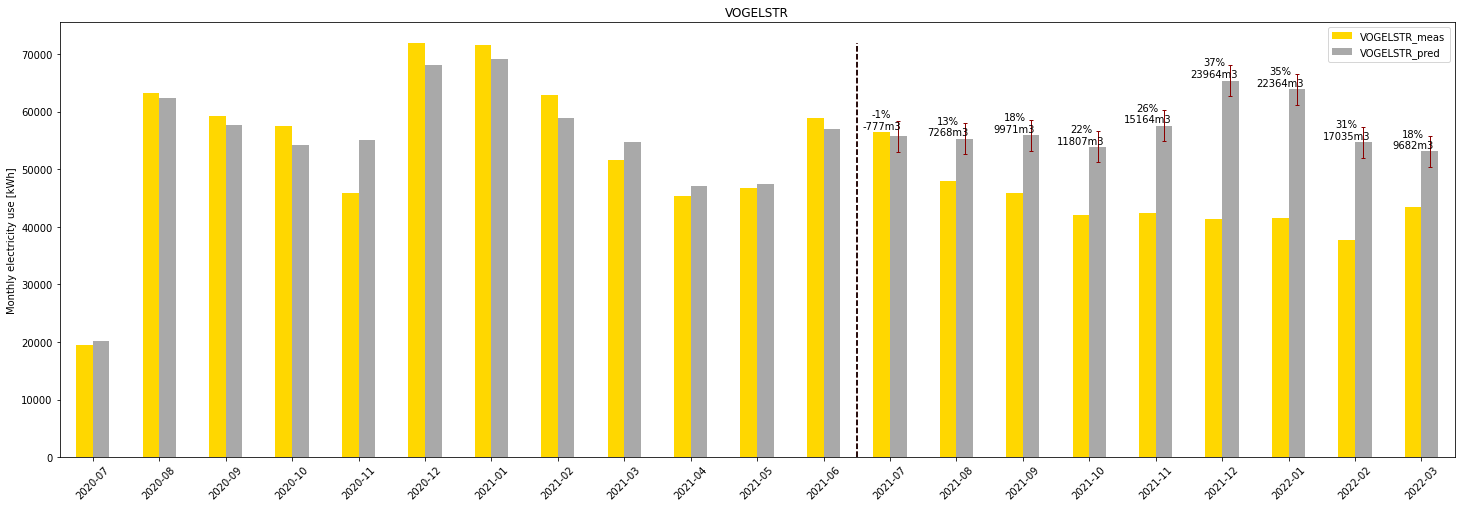

18026.55583377679


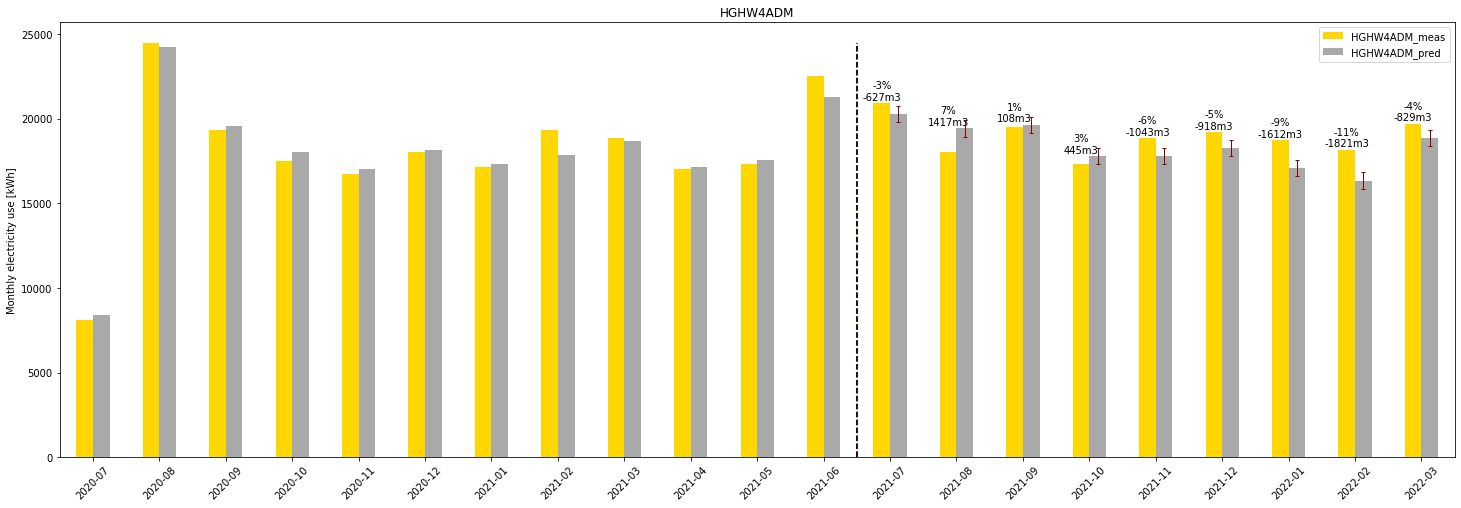

67867.49964582222


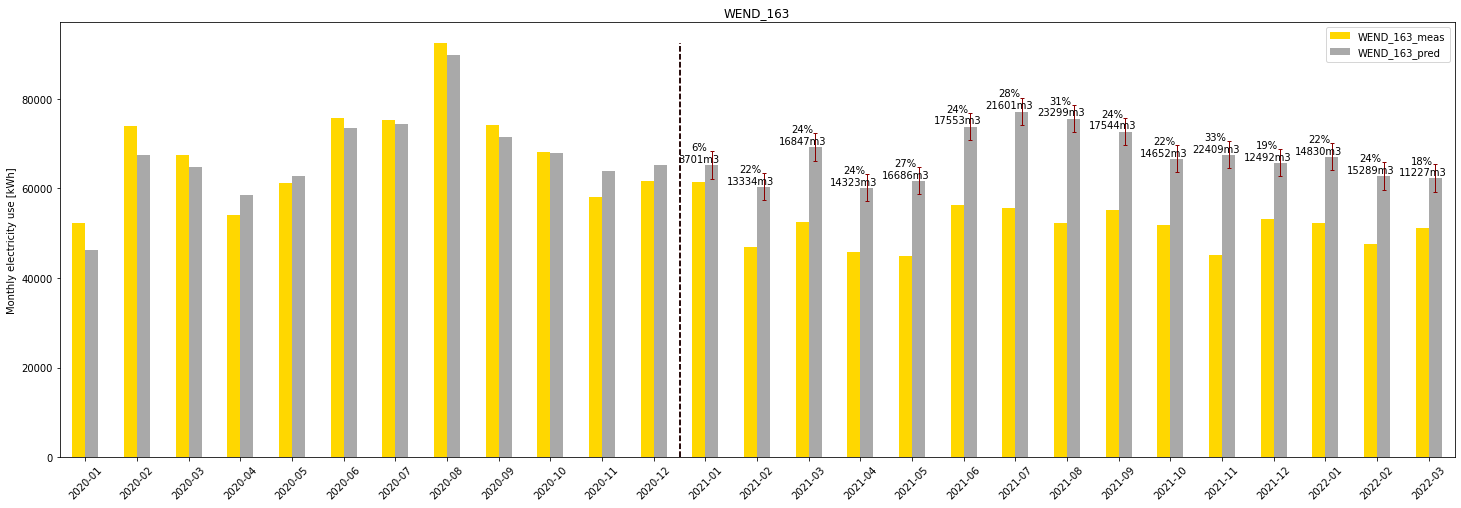

In [881]:
for building in electr_use.columns:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(electr_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(electr_use_pred[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pred'})
    #
    df_compare = df_compare.resample('m').sum()
    soc = socs[building]#.date()
    
    # print(df_compare[building+"_meas"].loc[soc-relativedelta(months=+12):soc].mean()) ##new, could be revisitied in the future

    soc_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=soc)
    train_end_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=train_periods.loc[building, 'end'])
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    err = pd.DataFrame(index=df_compare.index, data={fr'{building}_pred':train_pred_mae[building]})
    err.iloc[:int(soc_pos) + 1] = np.nan
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgray'], yerr=err,
                        error_kw=dict(ecolor='darkred', lw=1, capsize=2, capthick=1))
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]
    for i, p in enumerate(patches[0:int(len(patches)/2)]):
        if i > soc_pos:
            saving = int(month_savings[building].iloc[i].round(0))
            saving_m3 = int(month_savings_m3[building].iloc[i].round(0))
            width = p.get_width()
            height = max(p.get_height(), patches_p[i].get_height())
            x, y = p.get_xy()
            ax.annotate(f'{saving}%\n{saving_m3}m3', (x + width/2, y + height*1.01), ha='center')
    #
    plt.ylabel('Monthly electricity use [kWh]')
    plt.title(building)
    plt.show(block=False)

In [797]:
# calculate monthly portfolio savings
electr_use_pred_sav = electr_use_pred
electr_use_meas_sav = electr_use_meas
for building in electr_use.columns:
    electr_use_pred_sav.loc[electr_use_pred_sav.index[0]:socs[building], building] = np.nan
    electr_use_meas_sav.loc[electr_use_meas_sav.index[0]:socs[building], building] = np.nan
electr_use_sav = electr_use_pred_sav - electr_use_meas_sav
electr_use_sav = electr_use_sav.resample('m').sum()
electr_use_sav = electr_use_sav.loc[socs[electr_eans.index].min():]

In [798]:
for building in electr_use_sav.columns:
    print(building, "total savings since SOC (kWh):", electr_use_sav[building].sum())

GPR_EH total savings since SOC (kWh): 698312.9496785644
HGHW8ADM total savings since SOC (kWh): 148543.8094611168
KRSD8ADM total savings since SOC (kWh): 73302.77939087152
VOGELSTR total savings since SOC (kWh): 117763.69032287598
HGHW4ADM total savings since SOC (kWh): -3762.920021057129
WEND_163 total savings since SOC (kWh): 235423.64309757855


In [806]:
round(electr_use_sav.sum(),2)

GPR_EH      698312.95
HGHW8ADM    148543.81
KRSD8ADM     73302.78
VOGELSTR    117763.69
HGHW4ADM     -3762.92
WEND_163    235423.64
dtype: float64

In [804]:
round(electr_use_sav.sum().sum(),2)

1269583.95

In [803]:
round(electr_use_sav.sum().sum()*0.23,2)

292004.31

### Monthly portfolio savings

In [780]:
electr_use_pred_sav = electr_use_pred
electr_use_meas_sav = electr_use_meas
for building in electr_use.columns:
    electr_use_pred_sav.loc[electr_use_pred_sav.index[0]:socs[building], building] = np.nan
    electr_use_meas_sav.loc[electr_use_meas_sav.index[0]:socs[building], building] = np.nan
electr_use_sav = electr_use_pred_sav - electr_use_meas_sav
electr_use_sav = electr_use_sav.resample('m').sum()
electr_use_sav = electr_use_sav.loc[socs[electr_use.columns].min():]
electr_use_sav['m3_cost']=0.76 #assuming cost of m3 is 0.76 cents, could be changed
for col in electr_use_sav.columns:
    electr_use_sav[col]=round(electr_use_sav['m3_cost']*electr_use_sav[col],2)
del electr_use_sav['m3_cost']

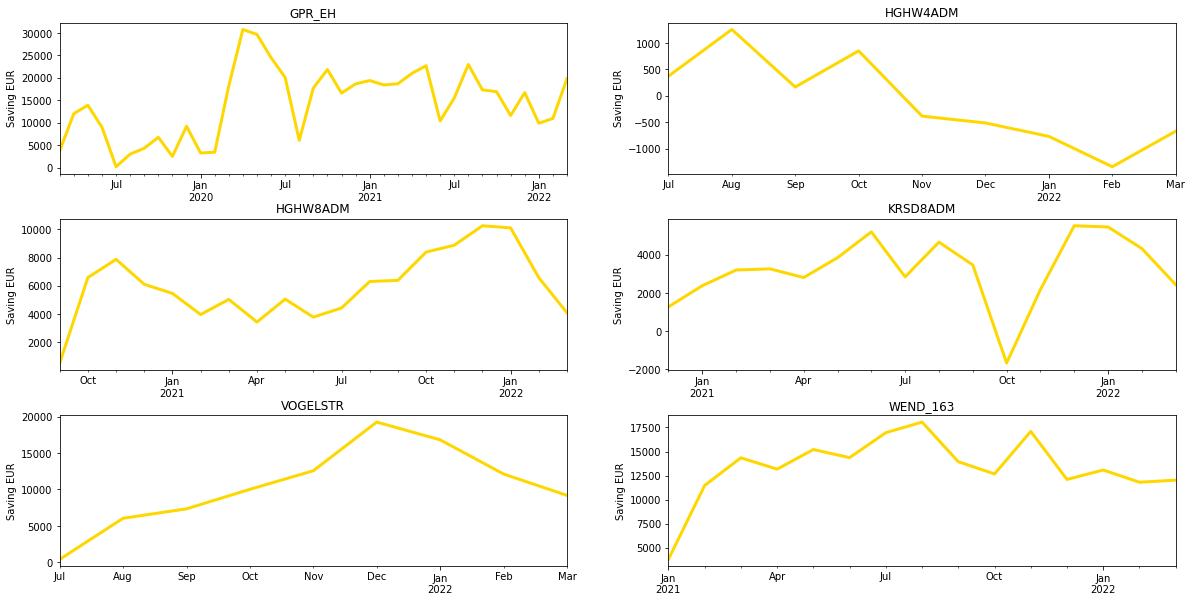

In [781]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)
for col, ax in zip(sorted(electr_use_sav.columns), axs.ravel()):
    index=electr_use_sav[col].index.get_loc(electr_use_sav[col].ne(0).idxmax())
    electr_use_sav[[col]].iloc[index:,].plot(ax=ax, color='gold', linewidth=3) #excludes April for now, too early in the month to draw results
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_ylabel("Saving EUR")

# Forecasting

In [205]:
# forecasted features variables are read in which are daily averages from histrorical values (10 years of data)

In [714]:
#forecast periods are defined, which is - per building - SOC up until 31st of March 2022
forecast_periods=pd.DataFrame()
forecast_periods['start'] = socs[electr_use.columns]
forecast_periods['end'] = pd.Timestamp('2022-03-31')
forecast_periods=forecast_periods[~forecast_periods.index.duplicated(keep='first')]
forecast_periods

,start,end
GPR_EH,2019-03-15,2022-03-31
HGHW8ADM,2020-09-06,2022-03-31
KRSD8ADM,2020-12-10,2022-03-31
VOGELSTR,2021-07-21,2022-03-31
HGHW4ADM,2021-07-20,2022-03-31
WEND_163,2021-01-11,2022-03-31


In [715]:
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                              end=forecast_periods['end'].max(),
                                              freq=time_res))

# pulls data from sp-ql
electr_builds = ['GPR_EH', 'HGHW8ADM', 'KRSD8ADM', 'VOGELSTR', 'HGHW4ADM', 'WEND_163']
for building in [b for b in build_names if b in electr_builds]:
#skips buildings with no electricity EAN data
    start = forecast_periods.loc[building, 'start']
    end = forecast_periods.loc[building, 'end']
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use = electr_use.join(electr)
        #else:
            #print(fr'{building} - electricity EAN:{electr_eans[building]} not found')
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use = electr_use.join(electr)
            #else:
                #print(fr'{building} - electricity EAN:{ean} not found')
electr_use = electr_use.resample('d').sum() #sums the kWh to daily readings
filter_col = [col for col in electr_use if col.startswith('WEND')] #filters the buildings that start with input name
electr_use[filter_col]=electr_use[filter_col].fillna(0) #adds 0's for NaN's for summation of electricity usage
electr_use['WEND_ALL']=electr_use[filter_col].sum(axis=1) #summation of all buildings with name filter
electr_use['WEND_ALL']=electr_use['WEND_ALL'].replace({'0':np.nan, 0:np.nan}) #replacing the 0's back for NaN's
electr_use=electr_use.drop(['WEND_163_871685920002511933', 'WEND_163_871685900041513587'], axis=1)
electr_use.rename(columns = {'GPR_EH_871688730000013981':'GPR_EH', 'HGHW8ADM_871685900000033811':'HGHW8ADM', 'KRSD8ADM_871685900000033903':'KRSD8ADM', 
                                     'VOGELSTR_871685900000033682':'VOGELSTR', 'HGHW4ADM_871685900000033798':'HGHW4ADM', 'TUPLEV65_871685900007082409':'TUPLEV65',
                             'WEND_ALL':'WEND_163'}, inplace = True)

### Random Forest

In [730]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    
    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    features['dow'] = features.index.dayofweek
    electr_use_train_build = electr_use[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'MERIN_electr/data/trained_models/f_rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_electr/data/trained_models/f_rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_electr/data/trained_models/f_rf/y_test_{building}.joblib')

Training building GPR_EH, 1/6
Training building HGHW8ADM, 2/6
Training building KRSD8ADM, 3/6
Training building VOGELSTR, 4/6
Training building HGHW4ADM, 5/6
Training building WEND_163, 6/6


### Gradient Boosting

In [718]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    
    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    features['dow'] = features.index.dayofweek
    electr_use_train_build = electr_use[building]
    
    #X = features.loc['2019-03-15':'2022-03-31']
    X = features[(features.index >= start_train) & (features.index < end_train)]


    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }
    
    rf = GradientBoostingRegressor()
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                        cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    
    joblib.dump(grid_search.best_estimator_, fr'MERIN_electr/data/trained_models/f_gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_electr/data/trained_models/f_gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_electr/data/trained_models/f_gb/y_test_{building}.joblib')

Training building GPR_EH, 1/6
Training building HGHW8ADM, 2/6
Training building KRSD8ADM, 3/6
Training building VOGELSTR, 4/6
Training building HGHW4ADM, 5/6
Training building WEND_163, 6/6


### XGBoosting

In [732]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    
    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    features['dow'] = features.index.dayofweek
    electr_use_train_build = electr_use[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)

    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'MERIN_electr/data/trained_models/f_xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_electr/data/trained_models/f_xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_electr/data/trained_models/f_xg/y_test_{building}.joblib')

Training building GPR_EH, 1/6
Training building HGHW8ADM, 2/6
Training building KRSD8ADM, 3/6
Training building VOGELSTR, 4/6
Training building HGHW4ADM, 5/6
Training building WEND_163, 6/6


### Predictions

In [833]:
warnings.filterwarnings("ignore")
electr_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in electr_use.columns:
        # select weather data for prediction

        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]

        # preapare features for prediction

        if knmi_station==240:
            features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
        if knmi_station==344:
            features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
        if knmi_station==370:
            features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
        if knmi_station==260:
            features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
        if knmi_station==275:
            features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

        features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

        features['dow'] = features.index.dayofweek

        electr_use_train_build = electr_use[building]
        X_pred = features #using KNMI weather data 2011-2022/04 and the trained model, predictions are made on energy consumption
        models = os.listdir(f'MERIN_electr/data/trained_models/f_{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/f_{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        electr_use_pred[building+'_'+m] = y_pred #gives energy consumption for model for building 2011-2022
        #print(electr_use_pred)

In [834]:
#ensemble stacking, equal weight
electr_use_pred['GPR_EH_en']=(electr_use_pred['GPR_EH_rf']+electr_use_pred['GPR_EH_gb']+electr_use_pred['GPR_EH_xg'])/3
electr_use_pred['HGHW8ADM_en']=(electr_use_pred['HGHW8ADM_rf']+electr_use_pred['HGHW8ADM_gb']+electr_use_pred['HGHW8ADM_xg'])/3
electr_use_pred['KRSD8ADM_en']=(electr_use_pred['KRSD8ADM_rf']+electr_use_pred['KRSD8ADM_gb']+electr_use_pred['KRSD8ADM_xg'])/3
electr_use_pred['VOGELSTR_en']=(electr_use_pred['VOGELSTR_rf']+electr_use_pred['VOGELSTR_gb']+electr_use_pred['VOGELSTR_xg'])/3
electr_use_pred['HGHW4ADM_en']=(electr_use_pred['HGHW4ADM_rf']+electr_use_pred['HGHW4ADM_gb']+electr_use_pred['HGHW4ADM_xg'])/3
electr_use_pred['WEND_163_en']=(electr_use_pred['WEND_163_rf']+electr_use_pred['WEND_163_gb']+electr_use_pred['WEND_163_xg'])/3

### Actual

In [835]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use_meas = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                              end=knmi_weather.index[-49]+dt.timedelta(30),
                                              freq=time_res))
# pulls data from sp-ql
electr_builds = ['GPR_EH', 'HGHW8ADM', 'KRSD8ADM', 'VOGELSTR', 'HGHW4ADM', 'WEND_163']
for building in [b for b in build_names if b in electr_builds]:
    start = forecast_periods['start'].min()
    end = knmi_weather.index[-1]+dt.timedelta(28)
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use_meas = electr_use_meas.join(electr)
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use_meas = electr_use_meas.join(electr)
                
electr_use_meas = electr_use_meas.resample('d').sum()
filter_col = [col for col in electr_use_meas if col.startswith('WEND')] #filters the buildings that start with input name
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0) #adds 0's for NaN's for summation of electricity usage
electr_use_meas['WEND_ALL']=electr_use_meas[filter_col].sum(axis=1) #summation of all buildings with name filter
electr_use_meas['WEND_ALL']=electr_use_meas['WEND_ALL'].replace({'0':np.nan, 0:np.nan}) #replacing the 0's back for NaN's
electr_use_meas=electr_use_meas.drop(['WEND_163_871685920002511933', 'WEND_163_871685900041513587'], axis=1)
electr_use_meas.rename(columns = {'GPR_EH_871688730000013981':'GPR_EH', 'HGHW8ADM_871685900000033811':'HGHW8ADM', 'KRSD8ADM_871685900000033903':'KRSD8ADM', 
                                     'VOGELSTR_871685900000033682':'VOGELSTR', 'HGHW4ADM_871685900000033798':'HGHW4ADM', 'TUPLEV65_871685900007082409':'TUPLEV65',
                             'WEND_ALL':'WEND_163'}, inplace = True)

In [836]:
def calc_date_pos_on_plot(df_compare_monthly):
    soc=pd.Timestamp('2022-04-01 00:00:00')
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

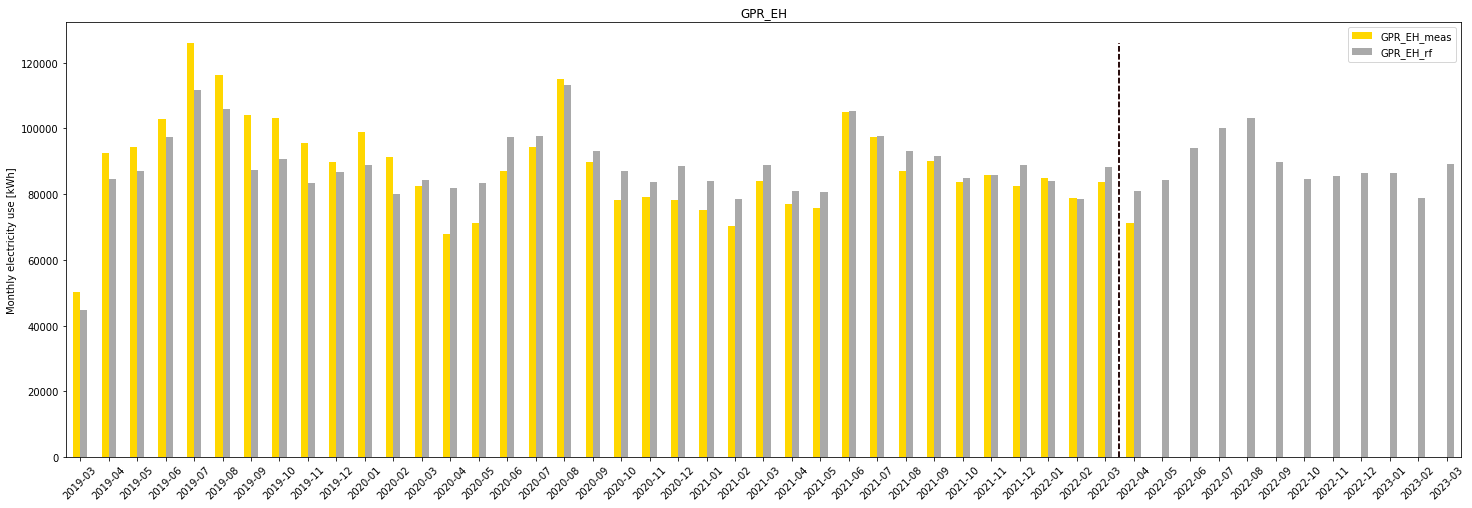

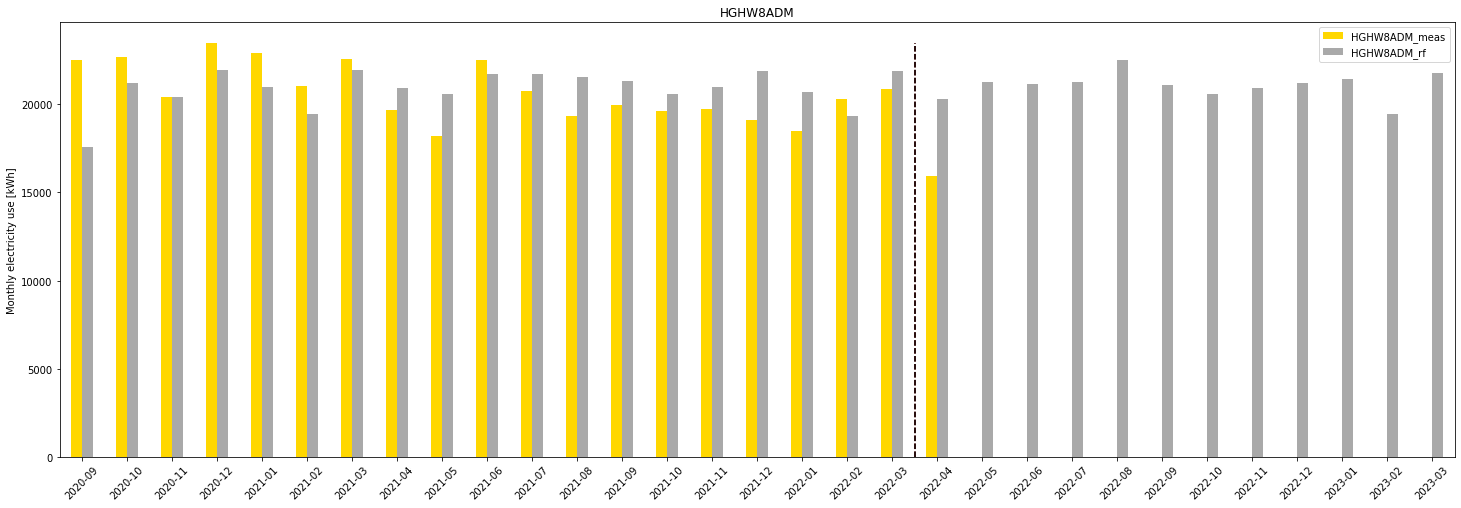

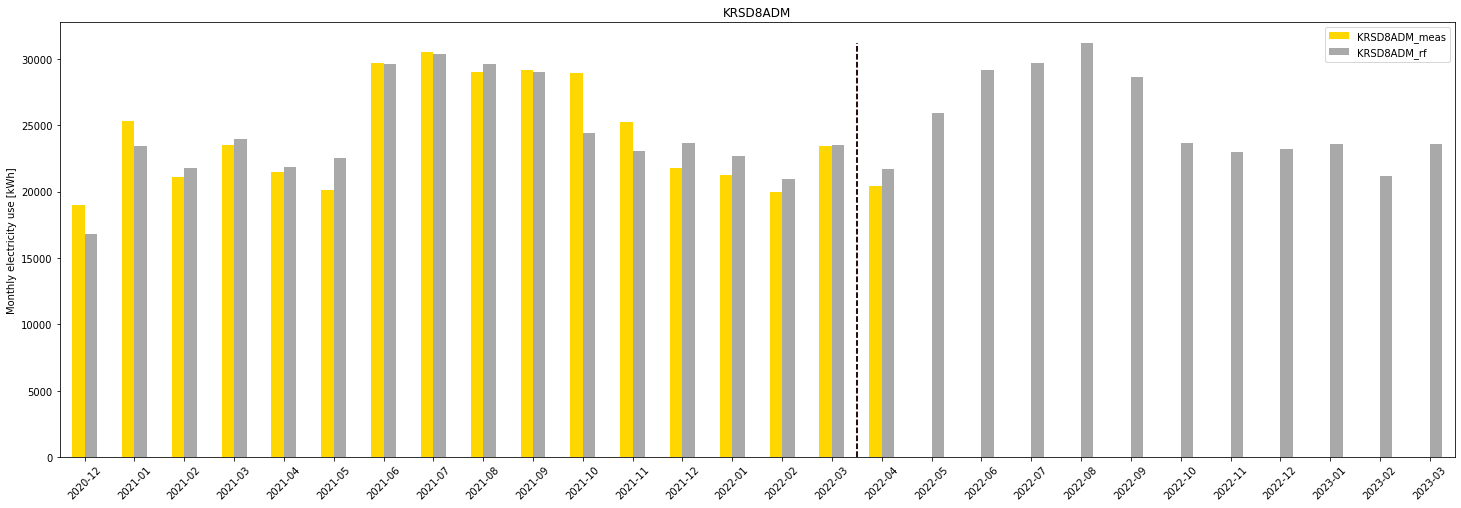

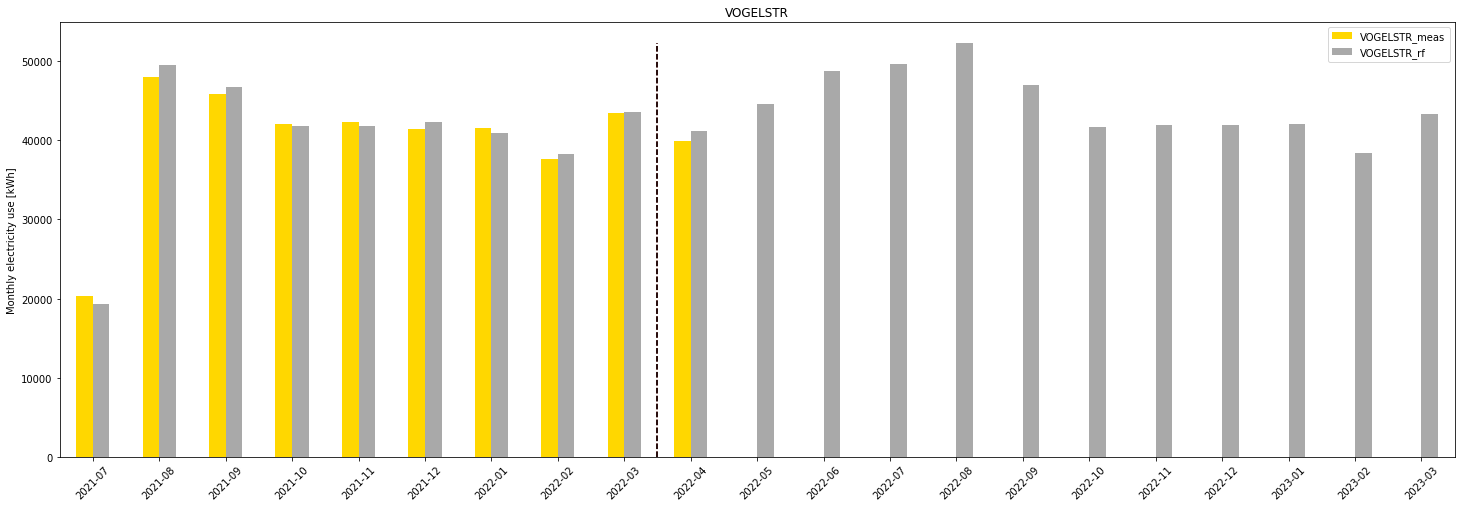

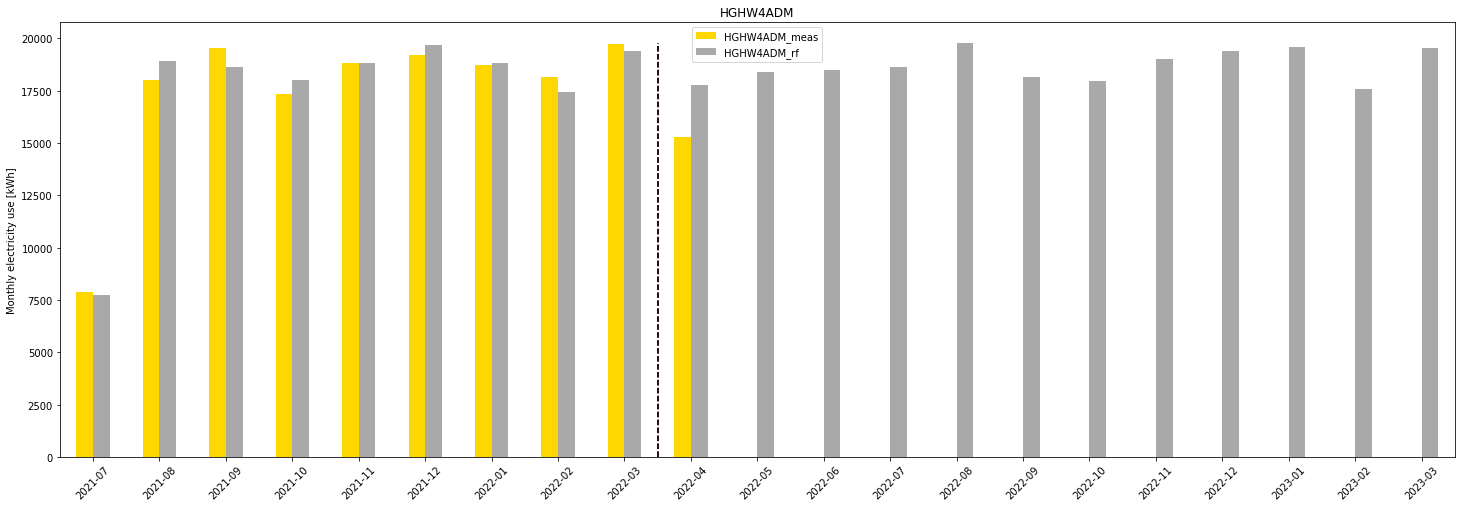

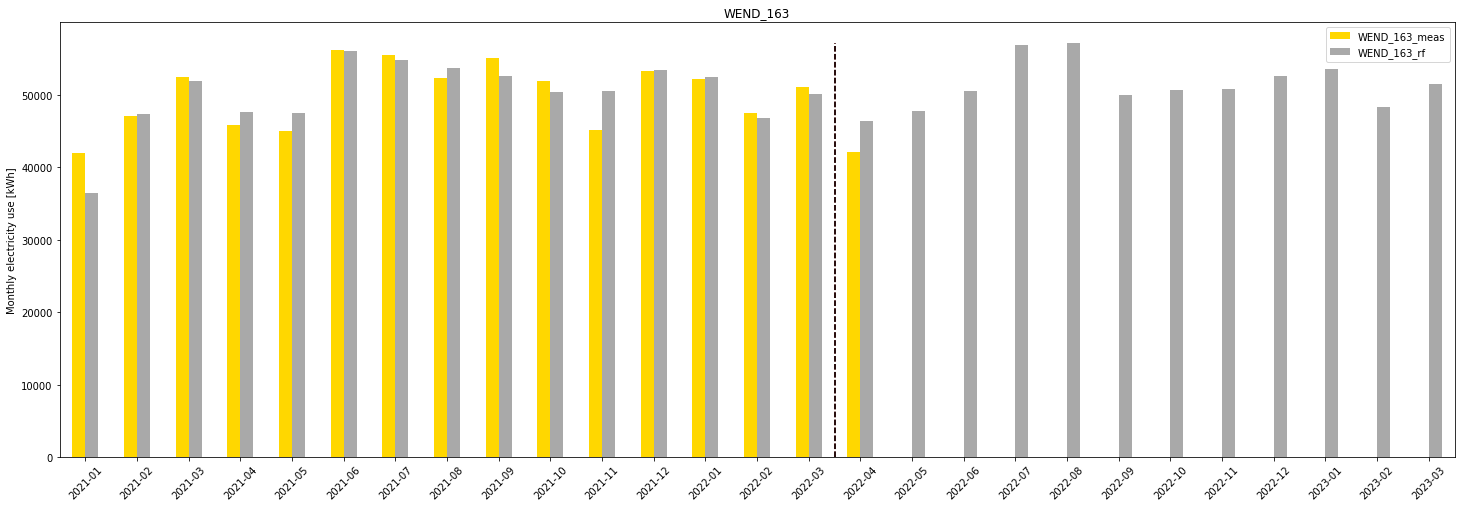

In [845]:
for building in electr_use.columns:
    start = forecast_periods.loc[building, 'start']
    end = electr_use_pred.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(electr_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(electr_use_pred[[building+"_rf"]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    #
    df_compare = df_compare.resample('m').sum()

    soc = socs[building]#.date()
    soc_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    train_end_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgray'], yerr=err,
                        error_kw=dict(ecolor='darkred', lw=1, capsize=2, capthick=1))
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]

    plt.ylabel('Monthly electricity use [kWh]')
    plt.title(building)
    plt.show(block=False)

In [738]:
metric_com_mae = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'MERIN_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        electr_use_train_build = electr_use[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

In [739]:
metric_com_rmse = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'MERIN_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

In [740]:
en_mae = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'MERIN_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]
    

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent

### MAEs

In [741]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                RF        GB        XG        EN
GPR_EH    3.993795  5.674837  4.063351  4.184917
HGHW8ADM  6.149351  7.505384  6.028454  4.431282
KRSD8ADM  7.738507  8.877129  7.253770  5.021704
VOGELSTR  4.620836  5.335685  3.598523  3.386769
HGHW4ADM  4.697947  5.880302  4.953748  3.164908
WEND_163  6.241244  6.080696  5.122779  4.019202


Average MAEs


RF    5.57361
GB    6.55901
XG    5.17010
EN    4.03480
dtype: float64

In [742]:
en_rmse = pd.DataFrame(index=electr_use.columns) #verander naam van variabele
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'MERIN_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent

### RMSEs

In [744]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                 RF         GB        XG        EN
GPR_EH     5.553545   7.985738  5.584529  5.584421
HGHW8ADM   8.613264   9.343515  8.445942  5.943629
KRSD8ADM  10.476459  11.042993  9.778710  6.526862
VOGELSTR   6.206599   6.512465  4.984091  4.261008
HGHW4ADM   5.992033   7.020470  6.401876  3.919266
WEND_163   8.284358   8.336785  7.133513  5.231287


Average RMSEs


RF    7.52104
GB    8.37366
XG    7.05478
EN    5.24441
dtype: float64

### Individual Predictions

In [885]:
warnings.filterwarnings("ignore")
electr_use_pred = pd.DataFrame(index=features.index)
for building in electr_use.columns:
    
    # select weather data for prediction

    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]

    # preapare features for prediction

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

    features['dow'] = features.index.dayofweek

    electr_use_train_build = electr_use[building]
    X_pred = features #using KNMI weather data 2011-2022/04 and the trained model, predictions are made on energy consumption
    models = os.listdir(f'MERIN_electr/data/trained_models/f_xg')
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_electr/data/trained_models/f_xg/trained_{building}.joblib')
    y_pred = grid_search.predict(X_pred)
    electr_use_pred[building] = y_pred #gives energy consumption for model for building 2011-2022
    #print(electr_use_pred)

In [887]:
electr_use_pred=electr_use_pred.loc['2022-04-01':,]
electr_use_pred=electr_use_pred.resample('m').sum()
electr_use_pred.mean()*0.23

GPR_EH      20505.964844
HGHW8ADM     4822.337891
KRSD8ADM     5908.415039
VOGELSTR    10057.279297
HGHW4ADM     4303.911621
WEND_163    11787.362305
dtype: float32